<a href="https://colab.research.google.com/github/NuongThach/web/blob/main/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!cd /gdrive/MyDrive/
!mkdir License_Plate_Detector

In [3]:
!cd /gdrive/MyDrive/
!mkdir License_Plate_Detector

mkdir: cannot create directory ‘License_Plate_Detector’: File exists


In [4]:
cd /gdrive/MyDrive/License_Plate_Detector

[Errno 2] No such file or directory: '/gdrive/MyDrive/License_Plate_Detector'
/content


In [ ]:
!pip3 install craft-text-detector

In [ ]:
!curl http://static.thanhniennews.com/Uploaded/minhhung/2015_10_15/bentley_UEUQ.jpg?width=840 > test.png

In [ ]:
!curl https://media.urbanistnetwork.com/saigoneer/article-images/2020/05/04/top1b.jpg > test2.png

In [ ]:
!curl https://vnn-imgs-f.vgcloud.vn/2021/09/28/14/vehicle-number-plates-to-be-auctioned.jpg > test3.png

In [ ]:
!pip3 install numpy==1.21.3

In [ ]:
!curl http://static.thanhniennews.com/Uploaded/minhhung/2015_10_15/bentley_UEUQ.jpg?width=840 > test.png

In [ ]:
!curl https://media.urbanistnetwork.com/saigoneer/article-images/2020/05/04/top1b.jpg > test2.png

In [ ]:
!curl https://vnn-imgs-f.vgcloud.vn/2021/09/28/14/vehicle-number-plates-to-be-auctioned.jpg > test3.png

In [ ]:
!pip3 install craft-text-detector

In [ ]:
# import Craft class
from craft_text_detector import Craft

# set image path and export folder directory
image = 'test3.png' # can be filepath, PIL image or numpy array
output_dir = 'outputs/'

# create a craft instance
craft = Craft(output_dir=output_dir, crop_type="poly", cuda=False)

# apply craft text detection and export detected regions to output directory
prediction_result = craft.detect_text(image)

# unload models from ram/gpu
craft.unload_craftnet_model()
craft.unload_refinenet_model()

In [ ]:
print(prediction_result)

In [17]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')
            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [23]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [19]:
import os
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from sklearn.metrics import f1_score

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras.optimizers 


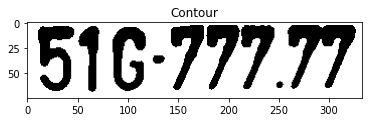

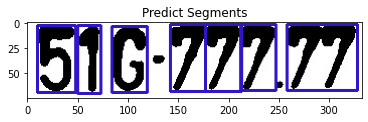

In [24]:
img=cv2.imread('/content/outputs/test3_crops/crop_2.png')
char=segment_characters(img)


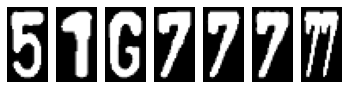

In [25]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '/content/outputs/'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics='accuracy')

In [ ]:
model.summary()

In [67]:
batch_size = 1
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 25, verbose=1, callbacks=None)

Epoch 1/25
198/198 [==============================] - 2s 7ms/step - loss: 2.2362 - accuracy: 0.2626 - val_loss: 2.7399 - val_accuracy: 0.3958
Epoch 2/25
198/198 [==============================] - 1s 5ms/step - loss: 0.9388 - accuracy: 0.6414 - val_loss: 3.5892 - val_accuracy: 0.4375
Epoch 3/25
198/198 [==============================] - 1s 5ms/step - loss: 0.3565 - accuracy: 0.8687 - val_loss: 4.8409 - val_accuracy: 0.4792
Epoch 4/25
198/198 [==============================] - 1s 5ms/step - loss: 0.1808 - accuracy: 0.9091 - val_loss: 4.8670 - val_accuracy: 0.4792
Epoch 5/25
198/198 [==============================] - 1s 7ms/step - loss: 0.1893 - accuracy: 0.9293 - val_loss: 5.0187 - val_accuracy: 0.5208
Epoch 6/25
198/198 [==============================] - 1s 6ms/step - loss: 0.0207 - accuracy: 1.0000 - val_loss: 6.5941 - val_accuracy: 0.5000
Epoch 7/25
198/198 [==============================] - 1s 5ms/step - loss: 0.0344 - accuracy: 0.9899 - val_loss: 6.2377 - val_accuracy: 0.5000
Epoch 

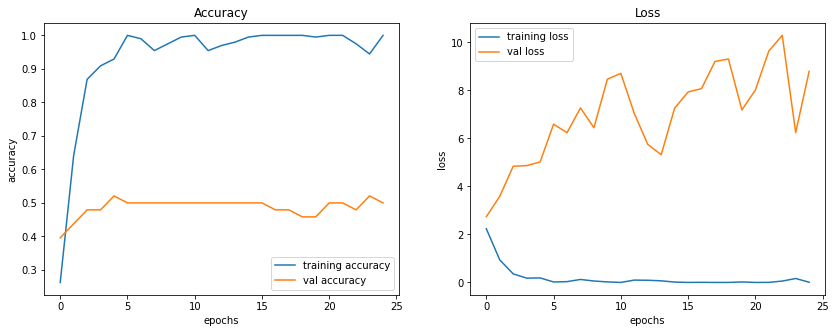

In [68]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [69]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

In [70]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('checkpoints/my_checkpoint')

In [73]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '01234567G89ABCDEFHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
       # y_ = loaded_model.predict_classes(img)[0] #predicting the class
        #predict_x=model.predict(img)[0]
        #y_=np.argmax(predict_x,axis=-1)
        y_ = np.argmax(model.predict(img)[0],axis=0)
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number
  

In [74]:
print(show_results())

51G7775


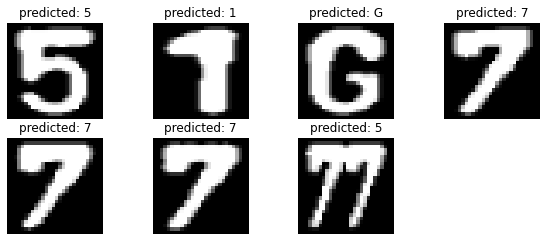

In [75]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()